In [1]:
"""
Test Script

"""
import random
import copy
import numpy as np
from vwgym import VacuumWorld, Vectorise, StepWrapper

from torch.distributions import Categorical
import matplotlib

import sys, os
sys.path.append(os.path.abspath('..'))
from fun_lite import *

random.seed(123518)

if torch.cuda.is_available():
    print('GPU Available:\t', True)
    device = 'cuda'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

else:
    device = 'cpu'

GPU Available:	 True


In [2]:
model_path = '../saved_model/trained_random_configs/vwgym_fnet_08_03_123518_ckpt.pt'

env, input_shape = make_env(grid_size=8, num_env=1, sparse=0, vectorize=True, random_seed=123518)
env = env[0]
env.state()

<class 'vacuumworld.vw.Grid'>: size: 8, agents: 1, dirts: 3, 
location(coordinate=coord(x=5, y=0), agent=None, dirt=dirt(name='D-3', colour='green'))
location(coordinate=coord(x=6, y=1), agent=None, dirt=dirt(name='D-1', colour='orange'))
location(coordinate=coord(x=6, y=4), agent=agent(name='A-1', colour='white', orientation='east'), dirt=None)
location(coordinate=coord(x=4, y=7), agent=None, dirt=dirt(name='D-2', colour='orange'))


<class 'vacuumworld.vw.Grid'>: size: 8, agents: 1, dirts: 3, 
location(coordinate=coord(x=5, y=0), agent=None, dirt=dirt(name='D-3', colour='green'))
location(coordinate=coord(x=6, y=1), agent=None, dirt=dirt(name='D-1', colour='orange'))
location(coordinate=coord(x=6, y=4), agent=agent(name='A-1', colour='white', orientation='east'), dirt=None)
location(coordinate=coord(x=4, y=7), agent=None, dirt=dirt(name='D-2', colour='orange'))

In [3]:
checkpoint = torch.load(model_path)
args = checkpoint['args']
checkpoint.keys()

dict_keys(['model', 'args', 'goal', 'man_state'])

In [4]:
num_actions = env.action_space.n
f_net = FuNet(input_shape, 256,
              10,
              0.001,
              16,
              num_actions,
              1, device)

In [5]:
f_net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [6]:
f_net

FuNet(
  (f_percept): Percept(
    (percept): Linear(in_features=132, out_features=256, bias=True)
  )
  (manager): Manager(
    (M_space): Linear(in_features=256, out_features=256, bias=True)
    (M_goals): Linear(in_features=256, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (M_value): Linear(in_features=512, out_features=1, bias=True)
  )
  (worker): Worker(
    (f_stateW): Linear(in_features=256, out_features=64, bias=True)
    (phi): Linear(in_features=256, out_features=16, bias=False)
    (wfc1): Linear(in_features=64, out_features=1024, bias=True)
    (wfc2): Linear(in_features=1024, out_features=512, bias=True)
    (W_value): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [7]:
goal_history = checkpoint['goal']
s_Mt_hist = checkpoint['man_state']

In [8]:
def take_action(action_probs):
    action = action_probs.max(1)[1]
    return action.cpu().numpy()

In [9]:
with torch.no_grad():

    f_net.eval()
    predictions = []
    goal_gen = []
    goal_rec = []
    phi = []
    figures = []
    
    x = env.reset()
    env.rw_dirts = env.dirts
    print(f'Dirts Present..:{env.rw_dirts}')
        
    x = torch.from_numpy(x).float()
    x = x.view(1, -1).to(device)
    
    step = 0
    prev_action = []
    
    for __ in range(5000):
        action_probs, v_Mt, v_Wt, goal_history, s_Mt_hist = f_net(x, goal_history, s_Mt_hist)

        goal_gen.append(goal_history[-1])
        goal_rec.append(goal_history[:args['len_hist'] + 1])

        a_t = take_action(action_probs)
        x, reward, done, ep_info = env.step(a_t[0])
        x = torch.from_numpy(x).float()
        x = x.view(1, -1).to(device)

        predictions.append(a_t[0])
        if done:
            break

Dirts Present..:3

Grid Cleaned !!

{'ep_rewards': 284, 'ep_len': 20, 'move': 13, 'clean': 4, 'turn_left': 3, 'turn_right': 0}
Episode Rewards:	 284 
 ----------------------------------------


In [10]:
import pandas as pd

p = pd.DataFrame.from_dict({'actions': predictions, 'action_meanings':[env.action_meanings[i] for i in predictions]})
p['action_meanings'].value_counts().reset_index()

,index,action_meanings
0,move,13
1,clean,4
2,turn_left,3


In [11]:
print('Action Sequence - FuN-Lite')
print('-'*20)
for i, a in enumerate([env.action_meanings[i] for i in predictions]):
    print('-', i, a)

Action Sequence - FuN-Lite
--------------------
- 0 turn_left
- 1 move
- 2 move
- 3 move
- 4 clean
- 5 move
- 6 turn_left
- 7 move
- 8 clean
- 9 move
- 10 turn_left
- 11 move
- 12 move
- 13 move
- 14 move
- 15 move
- 16 move
- 17 move
- 18 clean
- 19 clean


----
## Measuring Cosine Similarity of Goals

1 2 tensor([0.9854], device='cuda:0')
2 3 tensor([0.7463], device='cuda:0')
3 4 tensor([0.9969], device='cuda:0')
4 5 tensor([0.9378], device='cuda:0')
5 6 tensor([0.9229], device='cuda:0')
6 7 tensor([0.8912], device='cuda:0')
7 8 tensor([0.9959], device='cuda:0')
8 9 tensor([0.9887], device='cuda:0')
9 10 tensor([0.5197], device='cuda:0')
10 11 tensor([0.0707], device='cuda:0')
11 12 tensor([0.7544], device='cuda:0')
12 13 tensor([0.9524], device='cuda:0')
13 14 tensor([0.9836], device='cuda:0')
14 15 tensor([0.9811], device='cuda:0')
15 16 tensor([0.9427], device='cuda:0')
16 17 tensor([0.9792], device='cuda:0')
17 18 tensor([0.9692], device='cuda:0')
18 19 tensor([0.8507], device='cuda:0')
19 20 tensor([0.0112], device='cuda:0')


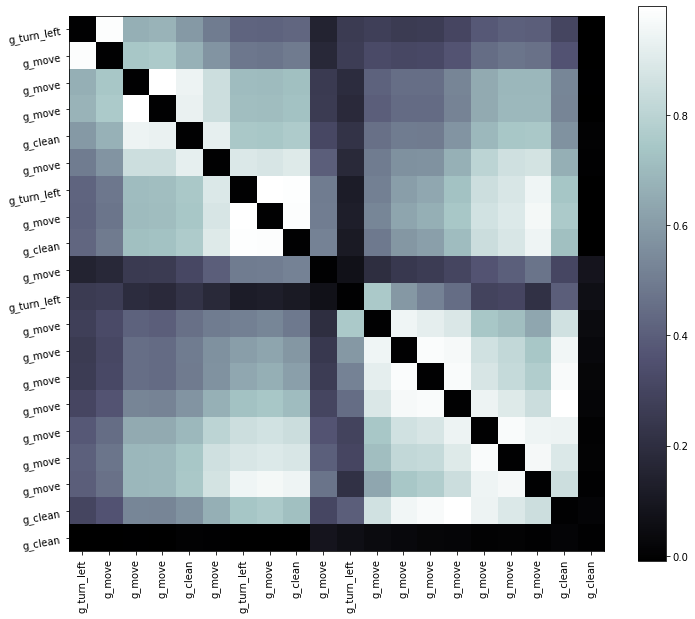

In [12]:
from torch.nn.functional import cosine_similarity as dcos
import matplotlib.pyplot as plt

for i, g in enumerate(zip(goal_gen[:-1], goal_gen[1:])):
    print(i+1, i+2, dcos(g[0], g[1]))

gm = np.zeros((len(goal_gen), len(goal_gen)))
for i, d1 in enumerate(goal_gen):
    for j, d2 in enumerate(goal_gen):
        if i == j:
            continue
        else:
            gm[i, j] = dcos(d1, d2)

am = [env.action_meanings[i] for i in predictions]

fig, ax = plt.subplots(figsize=(12, 12))

im = ax.imshow(gm, cmap='bone')

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

plt.xticks(ticks= [i for i in range(len(goal_gen))], 
           labels=[f'g_{am[i]}' for i in range(len(goal_gen))], rotation=90);
plt.yticks(ticks= [i for i in range(len(goal_gen))], 
           labels=[f'g_{am[i]}' for i in range(len(goal_gen))], rotation=10
          );
cbar = fig.colorbar(im, shrink=0.85)

In [13]:
fig.savefig('../saved_model/trained_random_configs/plots/cos_dist_123518')

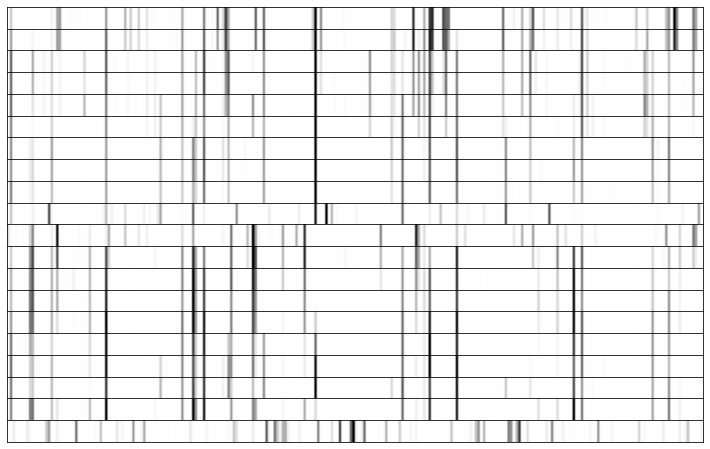

In [14]:
fig = plt.figure(figsize=(15, 8))
ax = [plt.subplot(len(goal_gen),1,i+1) for i in range(len(goal_gen))]

for g, a in enumerate(ax):
    x = goal_gen[g].detach().cpu().numpy()
    q = np.zeros((8, 256))
    for k in range(8):
        q[k, :] = x
    a.imshow(q, cmap='Greys');
    a.set_xticklabels([], visible=False)
    a.set_yticklabels([], visible=False)
    a.tick_params(axis=u'both', which=u'both',length=0)

plt.subplots_adjust(wspace=0, hspace=0.0)

In [15]:
fig.savefig('../saved_model/trained_random_configs/plots/manager_goals_123518')

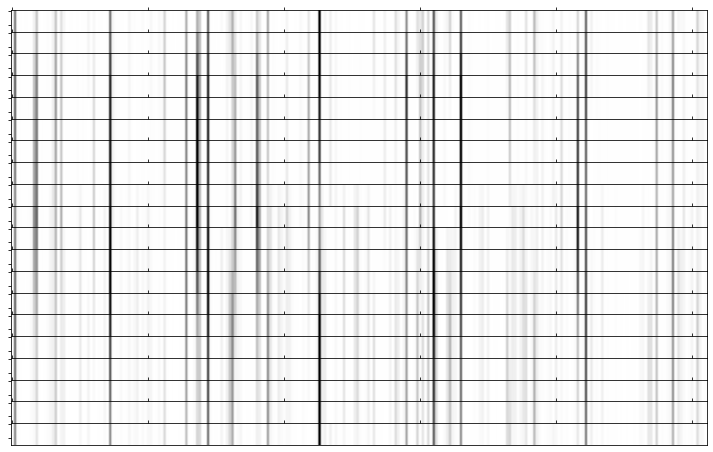

In [16]:
fig = plt.figure(figsize=(15, 8))
ax = [plt.subplot(len(goal_rec),1,i+1) for i in range(len(goal_rec))]

for g, a in enumerate(ax):
    x = [i.detach().cpu().numpy()[0] for i in goal_rec[g]]
    x = np.sum(x, axis=0).reshape(1, 256)
    q = np.zeros((8, 256))
    for k in range(8):
        q[k, :] = x
    a.imshow(q, cmap='Greys');
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0.0)

In [17]:
fig.savefig('../saved_model/trained_random_configs/plots/worker_goals_123518')